In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    """Compute the great-circle distance between two points (in meters)."""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

def compute_distances(df):
    """Recompute safe haversine distance per device, avoiding cross-device errors."""
    df = df.sort_values(by=["deviceid", "date", "time"]).copy()

    # Shift lat/lon and deviceid
    df["lat_prev"] = df.groupby("deviceid", observed=False)["lat"].shift()
    df["lon_prev"] = df.groupby("deviceid", observed=False)["lon"].shift()
    df["deviceid_prev"] = df["deviceid"].shift()

    # Compute haversine distance
    raw_dist = haversine(
        df["lat_prev"], df["lon_prev"],
        df["lat"], df["lon"]
    )

    # Only keep distance where device hasn't changed
    same_device = df["deviceid"] == df["deviceid_prev"]
    df["dist_m"] = raw_dist.where(same_device, 0).fillna(0)

    return df.drop(columns=["lat_prev", "lon_prev", "deviceid_prev"])

def add_device_trip_duration(df: pd.DataFrame):
    df = df.sort_values(["deviceid", "datetime"]).copy()
    trip_bounds = df.groupby("deviceid", observed=False)["datetime"].agg(["min", "max"])
    trip_bounds["trip_duration_s"] = (trip_bounds["max"] - trip_bounds["min"]).dt.total_seconds()
    
    return df.merge(trip_bounds["trip_duration_s"], on="deviceid")

def save_daily_distance_parquet(df, date_str="20230331"):
    output_dir = Path("Leons_output")
    output_dir.mkdir(parents=True, exist_ok=True)

    df = compute_distances(df)
    
    df = add_device_trip_duration(df)
    
    distance_summary = (
        df.groupby("deviceid", observed=False)[["dist_m", "trip_duration_s"]]
          .agg({"dist_m": "sum", "trip_duration_s": "first"})  # duration is same across rows per device
          .reset_index()
          .rename(columns={"dist_m": "daily_distance_m"})
    )

    # Identify the device with the maximum distance
    max_row = distance_summary.loc[distance_summary["daily_distance_m"].idxmax()]
    max_device = max_row["deviceid"]
    max_distance = max_row["daily_distance_m"]

    # Print summary statistics
    print(f"Stats for {date_str}:")
    print(f"Unique devices: {distance_summary['deviceid'].nunique()}")
    print(f"Total distance: {distance_summary['daily_distance_m'].sum()/1000:.2f} km")
    print("Distance summary (in meters):")
    print(distance_summary["daily_distance_m"].describe())
    print(f"🚀 Device with max distance: {max_device} ({max_distance/1000:.2f} km)")

    # Save to CSV
    output_path = output_dir / f"daily_distance_{date_str}.csv"
    distance_summary.drop(columns=["deviceid"]).to_csv(output_path, index=False)
    print(f"Saved daily distances to: {output_path}")


df = pd.read_parquet("data_denoised/20230331.parquet")
save_daily_distance_parquet(df, date_str="20230331")

Stats for 20230331:
Unique devices: 542576
Total distance: 55842753.56 km
Distance summary (in meters):
count    5.425760e+05
mean     1.029215e+05
std      1.811115e+05
min      0.000000e+00
25%      4.407157e+03
50%      4.553477e+04
75%      1.364553e+05
max      2.280570e+07
Name: daily_distance_m, dtype: float64
🚀 Device with max distance: 40509.0 (22805.70 km)
Saved daily distances to: Leons_output/daily_distance_20230331.csv


In [5]:
# Checking for corruption of the output file
df = pd.read_csv("Leons_output/daily_distance_20230331.csv")
print(df.head(20))

                                             deviceid  daily_distance_m
0   0000017b2585d0077579529809744573449bd6759a40a5...     169514.744941
1   0000036de6daf5cf62e5eb0d6bde972f49fa96bfcc767b...          0.000000
2   00001265b1269dc674673e7f6717b07a3afae8ce8592e0...          0.000000
3   000037349483e2215d48a02e8c0afd55a2c2f3219ce54d...      13341.448160
4   000068ebb195009bfce99779588ea5169b8d57e3e6e4b9...      23241.253144
5   000069c54d4dcfcb477162f9ef82049373a9a2cb414ab6...          0.000000
6   0000716bd81a31f503fae19c446eb5c1883da9c201b191...      14797.193116
7   000078453dddf43bc7cfabc0192b583fec09a1cc95034f...          0.000000
8   000083ddabbce75b31b352866b455b9d247df9d6796a4f...          0.000000
9   00008f78161130c053b6bc3cc9911931d22e53db4c4689...       4341.848083
10  0000915a3f92da7aea1a390bee43f41aad2d4803d65be4...     788138.129327
11  000096135e132abb6503f89eda234e3187889a19d4e087...     313097.408564
12  0000ab78fdb9e445dad1698fe1bf50ce883ad4e6986c12...          0

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data for 2023-03-31
df = pd.read_parquet("data_transitions/20230331.parquet")

# Optional ensure FROM and TO are strings or ints (consistent format)
df["FROM"] = df["FROM"].astype(str)
df["TO"] = df["TO"].astype(str)

# Group by origin-destination and sum the counts across time bins
od_matrix = (
    df.groupby(["FROM", "TO"])["count"]
    .sum()
    .reset_index()
    .rename(columns={"count": "total_transitions"})
)

# Optional convert to a pivot table (FROM as rows, TO as columns)
od_pivot = od_matrix.pivot(index="FROM", columns="TO", values="total_transitions").fillna(0)

# Save to CSV if needed
od_pivot.to_csv("Leons_output/od_matrix_20230331.csv")

/d/hpc/home/jo83525/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


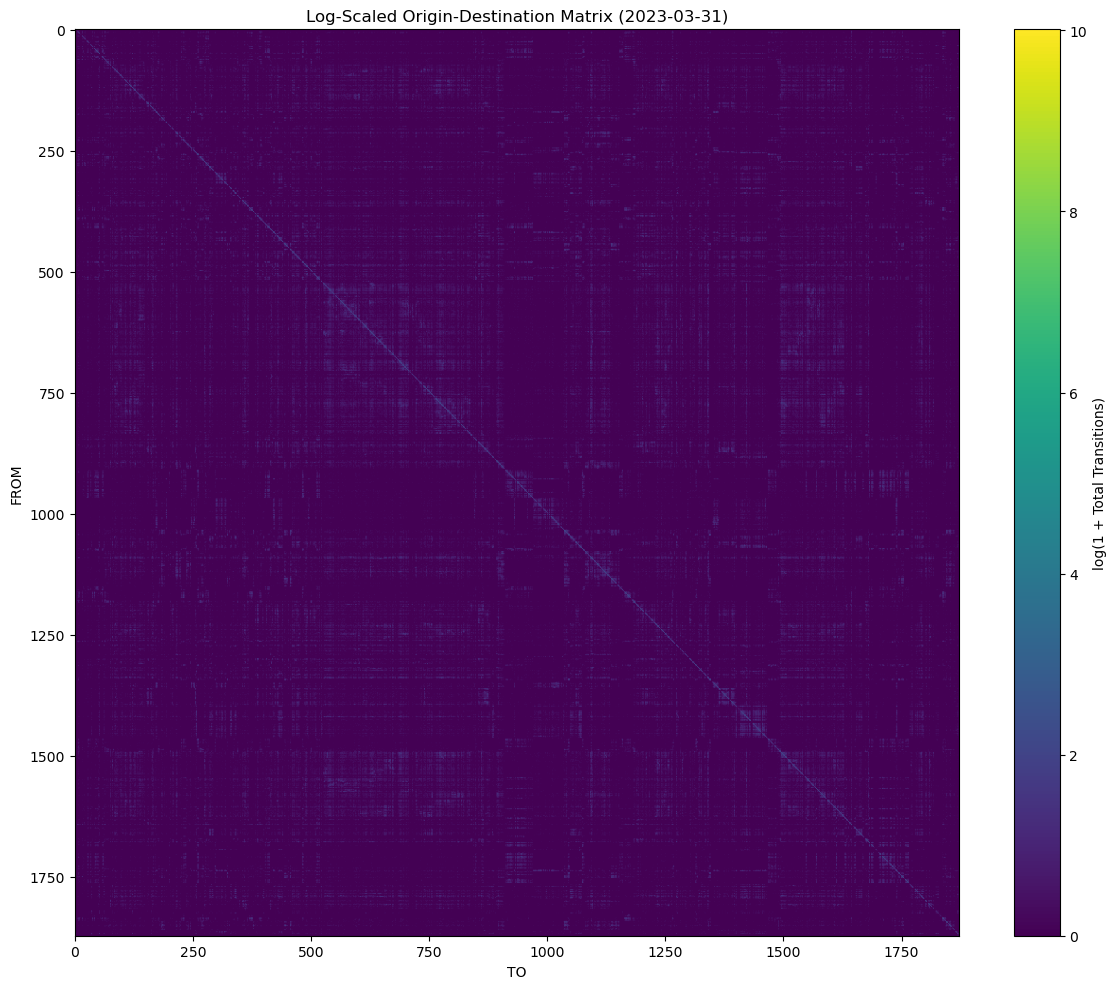

In [3]:

import numpy as np
df = pd.read_parquet("data_transitions/20230331.parquet")
df["FROM"] = df["FROM"].astype(str)
df["TO"] = df["TO"].astype(str)

all_zones = sorted(set(df["FROM"]) | set(df["TO"]))
od_pivot = (
    df.groupby(["FROM", "TO"])["count"]
    .sum()
    .unstack(fill_value=0)
    .reindex(index=all_zones, columns=all_zones, fill_value=0)
)


log_od = np.log1p(od_pivot.values)  # log1p(x) = log(1 + x), handles zeros
plt.figure(figsize=(12, 10))
plt.imshow(log_od, cmap="viridis", aspect="auto")
plt.colorbar(label="log(1 + Total Transitions)")
plt.title("Log-Scaled Origin-Destination Matrix (2023-03-31)")
plt.xlabel("TO")
plt.ylabel("FROM")
plt.tight_layout()
plt.show()

/cvmfs/sling.si/modules/el7/software/Anaconda3/2023.07-2/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


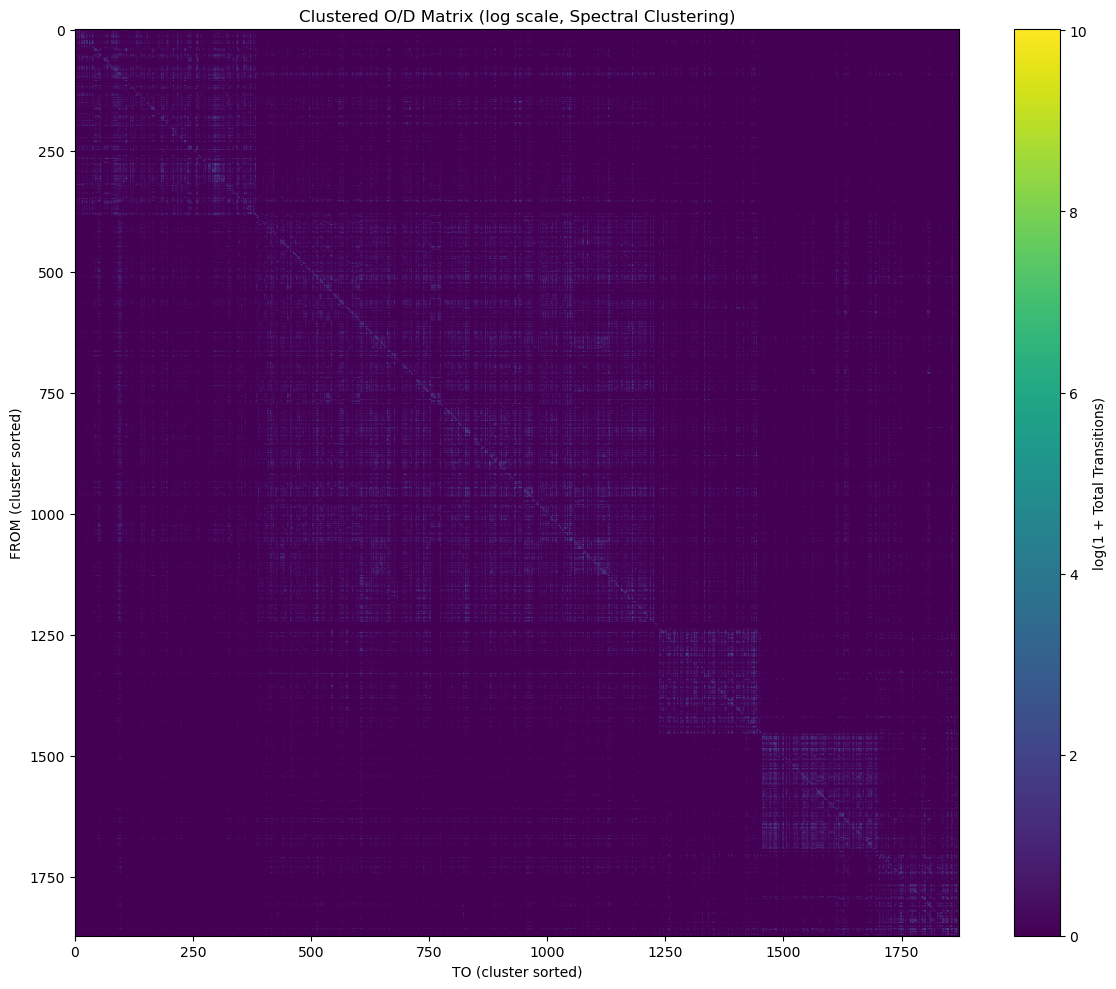

In [5]:
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Perform spectral clustering
n_clusters = 10  # Adjust this if needed
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='discretize', random_state=42)
labels = clustering.fit_predict(log_od + log_od.T)  # Ensure symmetry

# Reorder matrix by cluster labels
ordered_idx = np.argsort(labels)
reordered_matrix = log_od[ordered_idx][:, ordered_idx]

# Plot reordered matrix
plt.figure(figsize=(12, 10))
plt.imshow(reordered_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="log(1 + Total Transitions)")
plt.title("Clustered O/D Matrix (log scale, Spectral Clustering)")
plt.xlabel("TO (cluster sorted)")
plt.ylabel("FROM (cluster sorted)")
plt.tight_layout()
plt.show()

zones = od_pivot.index.tolist()  # correct zone_id order matching rows of log_od
zone_clusters = pd.DataFrame({
    "zone_id": zones,
    "cluster": labels
})


In [7]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === CONFIGURATION ===
geojson_path = "maps/minimalist_coning.geojson"
output_map_path = "clustered_zones_map.html"

# === 1. Load GeoJSON zones ===
gdf = gpd.read_file(geojson_path).to_crs("EPSG:4326")

# Ensure 'zone_id' exists
if "zone_id" not in gdf.columns:
    gdf["zone_id"] = pd.Series(range(len(gdf)), dtype="int32")

# === 2. Load cluster labels from spectral clustering ===
# Assume you already have this from your analysis:
# - `zones`: list of zone IDs in the matrix order
# - `labels`: np.array of cluster labels

# For this example, load from CSV if saved:
# zone_clusters = pd.read_csv("zone_clusters.csv")  # if previously saved

# If in memory:
# zone_clusters = pd.DataFrame({"zone_id": zones, "cluster": labels})

gdf["zone_id"] = gdf["zone_id"].astype(str)
zone_clusters["zone_id"] = zone_clusters["zone_id"].astype(str)

# === 3. Merge into GeoDataFrame ===
gdf = gdf.merge(zone_clusters, on="zone_id", how="left")

# === 4. Create a color map for clusters ===
n_clusters = gdf["cluster"].nunique()
cmap = cm.get_cmap("tab20", n_clusters)
cluster_colors = {i: colors.rgb2hex(cmap(i)) for i in range(n_clusters)}

# === 5. Create the Folium map ===
center = gdf.geometry.centroid.unary_union.centroid.coords[0][::-1]
m = folium.Map(location=center, zoom_start=9, tiles="CartoDB positron")

# Draw zones with cluster coloring
for _, row in gdf.iterrows():
    cluster = row["cluster"]
    color = cluster_colors.get(cluster, "#dddddd") if pd.notna(cluster) else "#dddddd"
    folium.GeoJson(
        row["geometry"],
        style_function=lambda feature, color=color: {
            "fillColor": color,
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.6
        },
        tooltip=f'Zone {row["zone_id"]} - Cluster {cluster}'
    ).add_to(m)

# === 6. Save the map ===
m.save(output_map_path)
print(f"Map saved to {output_map_path}")


/tmp/ipykernel_2372326/4263701801.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", n_clusters)
/tmp/ipykernel_2372326/4263701801.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf.geometry.centroid.unary_union.centroid.coords[0][::-1]
/tmp/ipykernel_2372326/4263701801.py:41: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = gdf.geometry.centroid.unary_union.centroid.coords[0][::-1]


Map saved to clustered_zones_map.html
